## 1. Import Libraries

In [55]:
#conda install -c conda-forge feature_engine


In [96]:
import numpy as np
import pandas as pd
import sklearn 
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (
    OneHotEncoder,
    MinMaxScaler,
    PowerTransformer,
    FunctionTransformer,
    OrdinalEncoder,
    StandardScaler
    
    
)

from feature_engine.outliers import Winsorizer
from feature_engine.datetime import DatetimeFeatures
from feature_engine.selection import SelectBySingleFeaturePerformance

from feature_engine.encoding import (
    RareLabelEncoder,
    MeanEncoder,
    CountFrequencyEncoder
    
)
import matplotlib.pyplot as plt
import warnings

## 2. Display Settings

In [97]:
# if we have lots of columns pandas will not show all of them by default
# but if we want to force pandas to show all columns we can write foll code

pd.set_option("display.max_columns",None)

In [98]:
sklearn.set_config(transform_output="pandas")
# by default scikit learn transformers in the output they return numpy arrays even if the input is dataframe or something else output is numpy arrayt
# so if we want scikit to output pandas dataframe itself then will us above code

In [99]:
warnings.filterwarnings("ignore")
# we might get some warnings frequently just to remove that we wrote this code

## 3. Read the Data

In [100]:
#  one important note whatever feature engg will do is only on training data so experimentation, analysis everything on training data

path = r"D:\SAURABH\spring 2024\ML_Projects\AWS SageMaker FlightFarePredictor\data\train_set.csv"

train = pd.read_csv(path)

train

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Indigo,2019-06-06,Kolkata,Banglore,20:25:00,23:10:00,165,0.0,No Info,4804
1,Air India,2019-05-21,Delhi,Cochin,17:15:00,19:15:00,1560,2.0,No Info,11989
2,Jet Airways,2019-03-24,Kolkata,Banglore,21:10:00,16:20:00,1150,1.0,In-flight meal not included,10031
3,Indigo,2019-04-01,Delhi,Cochin,14:20:00,17:35:00,195,0.0,No Info,4729
4,Jet Airways,2019-03-15,Mumbai,Hyderabad,10:20:00,11:50:00,90,0.0,No Info,8040
...,...,...,...,...,...,...,...,...,...,...
6690,Jet Airways,2019-05-09,Kolkata,Banglore,09:35:00,23:35:00,840,1.0,No Info,12121
6691,Jet Airways,2019-05-18,Kolkata,Banglore,09:35:00,19:10:00,575,1.0,No Info,13067
6692,Jet Airways,2019-05-24,Kolkata,Banglore,20:00:00,23:35:00,1655,1.0,In-flight meal not included,10844
6693,Multiple Carriers,2019-06-03,Delhi,Cochin,10:35:00,19:00:00,505,1.0,No Info,10877


In [101]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6695 entries, 0 to 6694
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   airline          6695 non-null   object 
 1   date_of_journey  6695 non-null   object 
 2   source           6695 non-null   object 
 3   destination      6695 non-null   object 
 4   dep_time         6695 non-null   object 
 5   arrival_time     6695 non-null   object 
 6   duration         6695 non-null   int64  
 7   total_stops      6695 non-null   float64
 8   additional_info  6695 non-null   object 
 9   price            6695 non-null   int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 523.2+ KB


In [102]:
# will split into x and y where x is input variable and y would be target column

X_train = train.drop(columns="price")
y_train = train.price.copy()

In [103]:
X_train.columns.to_list()

['airline',
 'date_of_journey',
 'source',
 'destination',
 'dep_time',
 'arrival_time',
 'duration',
 'total_stops',
 'additional_info']

## 4. Column wise Transformation Operations

### 4.1 airline

In [104]:
X_train.airline

0                  Indigo
1               Air India
2             Jet Airways
3                  Indigo
4             Jet Airways
              ...        
6690          Jet Airways
6691          Jet Airways
6692          Jet Airways
6693    Multiple Carriers
6694            Air India
Name: airline, Length: 6695, dtype: object

- **Airline is a categorical column.**
- **Transformation/Preprocessing for Categorical Columns:**
  - First, we will perform imputation if there are any missing values.
  - During EDA, we observed that some airline categories were very rare (less than 10%). We will group these rare categories into a single category named "Other."
  - Finally, we will apply one-hot encoding.

### Steps for Preprocessing the Airline Column

1. **Imputation:**
   - Check for any missing values in the `airline` column and impute them accordingly.

2. **Grouping Rare Categories:**
   - Identify the airline categories that appear less than 10% of the time in the dataset.
   - Group these rare categories into a new category named "Other."

3. **One-Hot Encoding:**
   - Apply one-hot encoding to the `airline` column to convert the categorical data into numerical format, which can be used in machine learning models.


In [105]:
airline_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("grouper", RareLabelEncoder(tol=0.1, replace_with="other", n_categories=2)),
    ("encoder", OneHotEncoder(sparse_output=False, handle_unknown="ignore"))
    
])

airline_transformer.fit_transform(X_train.loc[:, ["airline"]])
     
    

,airline_Air India,airline_Indigo,airline_Jet Airways,airline_Multiple Carriers,airline_other
0,0.0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...
6690,0.0,0.0,1.0,0.0,0.0
6691,0.0,0.0,1.0,0.0,0.0
6692,0.0,0.0,1.0,0.0,0.0
6693,0.0,0.0,0.0,1.0,0.0


**Code Explanation:**

We will call `airline_transformer = Pipeline` with the input steps.
- **What steps?** The transformation steps to apply on this column. It's a list of tuples.
- In each tuple, we will mention a list of transformers that we want to apply.

**First Transformer:** We want to apply `SimpleImputer` to impute the values. We used the most frequent values for imputation and named this transformer `imputer`.

**Second Transformer:** We wanted to group rare categories, so we named it `grouper` and used `RareLabelEncoder` with a tolerance of `0.1`. This means all categories that occur less than 10% will be grouped and called "other". We also set `n_categories=2` to ensure grouping occurs only if the variable has at least 2 categories.

**Third Transformer:** We will do one-hot encoding using `OneHotEncoder`. By default, scikit-learn stores it as a sparse matrix, which is a memory-saving technique where many values are zero. However, to see the output, we set `sparse_output=False`. We also set `handle_unknown="ignore"` to ensure that any unseen categories in the test or validation set are handled without errors. If an unseen category appears, it will create a new column and mark them as 0.

Then, we test it with `fit_transform`.

**Output Observation:**

- **Simple Imputer:** Missing values are now imputed.
- **Grouper:** Rare categories are categorized into "other."
- **One-Hot Encoding:** For each category, we have one separate column.

**Conclusion:**

The use of a pipeline allows us to list all the transformations we need to do in sequence. We just wrote 3 transformations, but we could write 10 or 100s in sequence, and it will execute them.


### 4.2 date_of_journey

In [106]:
X_train.date_of_journey

0       2019-06-06
1       2019-05-21
2       2019-03-24
3       2019-04-01
4       2019-03-15
           ...    
6690    2019-05-09
6691    2019-05-18
6692    2019-05-24
6693    2019-06-03
6694    2019-06-15
Name: date_of_journey, Length: 6695, dtype: object

- **Date-Time Column Transformation:**

  - **Object Type with Date Information:** Since this column contains date information, we will apply specific transformations to extract meaningful features from it.

  - **Feature Extraction from Date:**
    - We will extract features such as date, month, day of the week, and whether it was a weekend.
    - We will avoid extracting the year as all values are from 2019.
    - Additionally, we will extract the week and day of the week.

  - **Min-Max Scaling:** 
    - After extracting the features, we will apply Min-Max Scaling to convert all values between 0 and 1.
  
  - **Available Features from Datetime Column:**
    - For a comprehensive list of extractable features from a datetime column, you can refer to [Feature-Engine's Datetime Features Documentation](https://feature-engine.trainindata.com/en/latest/api_doc/datetime/DatetimeFeatures.html#feature_engine.datetime.DatetimeFeatures).
    
  - **Selected Features:**
    - We will extract the month, day, week, and day of the week from the date-time column.


In [107]:
feature_to_extract = ["month", "week", "day_of_week","day_of_year"]

doj_transformer = Pipeline(steps=[
     ("dt", DatetimeFeatures(features_to_extract=feature_to_extract, yearfirst=True)),
     ("scaler", MinMaxScaler())
])

doj_transformer.fit_transform(X_train.loc[:,["date_of_journey"]])

,date_of_journey_month,date_of_journey_week,date_of_journey_day_of_week,date_of_journey_day_of_year
0,1.000000,0.823529,0.500000,0.822034
1,0.666667,0.705882,0.166667,0.686441
2,0.000000,0.176471,1.000000,0.194915
3,0.333333,0.294118,0.000000,0.262712
4,0.000000,0.117647,0.666667,0.118644
...,...,...,...,...
6690,0.666667,0.588235,0.500000,0.584746
6691,0.666667,0.647059,0.833333,0.661017
6692,0.666667,0.705882,0.666667,0.711864
6693,1.000000,0.823529,0.000000,0.796610


- **Date of Journey Input:**
  - The extracted features from the date of journey include month, day, week, and day of the week.
  
- **Observations on Extracted Feature Values:**
  - The values of each feature vary, with some being single-digit and others being double-digit.
  - While this discrepancy in scale is not an issue for tree-based models, we will still scale the features for consistency.
  
- **Scaling in the Pipeline:**
  - To ensure all features are on the same scale, we will apply scaling within the pipeline.
  - This will help maintain uniformity and improve the performance of non-tree-based models.


### 4.3 source & destination

In [108]:
X_train.source

0       Kolkata
1         Delhi
2       Kolkata
3         Delhi
4        Mumbai
         ...   
6690    Kolkata
6691    Kolkata
6692    Kolkata
6693      Delhi
6694      Delhi
Name: source, Length: 6695, dtype: object

In [109]:
X_train.destination

0        Banglore
1          Cochin
2        Banglore
3          Cochin
4       Hyderabad
          ...    
6690     Banglore
6691     Banglore
6692     Banglore
6693       Cochin
6694       Cochin
Name: destination, Length: 6695, dtype: object

- **Grouping Rare Labels:**
  - We will group rare labels because there are a few values, like "Chennai," that are very rare.
  
- **Mean Encoding:**
  - Mean encoding involves calculating the average value of the target column for each category of a categorical variable. 
  - For example, if we have a categorical variable with values cat1, cat2, cat3, and our target variable is "price" (numerical), mean encoding will calculate the average price for each category and use these averages as the encoded values.

- **Power Transformer:**
  - A power transformer is applied to numerical variables to make the distribution of the data as symmetric as possible.
  - It transforms the input variable \( x \) using an algorithm that finds the optimal lambda value such that \( x \) raised to this lambda results in a transformed variable with a symmetric distribution.
  - Under the hood, the power transformer also applies a standard scaler to the data.


In [110]:
location_subset = X_train.loc[:, ["source", "destination"]]
location_subset
# this are the columns we want to work on right now 


,source,destination
0,Kolkata,Banglore
1,Delhi,Cochin
2,Kolkata,Banglore
3,Delhi,Cochin
4,Mumbai,Hyderabad
...,...,...
6690,Kolkata,Banglore
6691,Kolkata,Banglore
6692,Kolkata,Banglore
6693,Delhi,Cochin


In [111]:
location_pipe1 = Pipeline(steps=[
    ("grouper", RareLabelEncoder(tol=0.1, replace_with="other", n_categories=2)),
    ("encoder", MeanEncoder()),
    ("scaler", PowerTransformer())
])

location_pipe1.fit_transform(location_subset, y_train)

,source,destination
0,-0.154666,-0.173651
1,1.042355,1.040402
2,-0.154666,-0.173651
3,1.042355,1.040402
4,-1.853893,-0.834662
...,...,...
6690,-0.154666,-0.173651
6691,-0.154666,-0.173651
6692,-0.154666,-0.173651
6693,1.042355,1.040402


- **Mean Encoding Result:**
  - Each category in the categorical variable has been replaced by the mean value of the target variable ("price").
  - However, the range of these mean values can be quite large, which might affect the model performance.

- **Power Transformer:**
  - To address the issue of large range values, we will use a power transformer.
  - The power transformer will apply a transformation that makes the distribution of the data more symmetric.
  - It will also scale the values to a standard range, ensuring consistency and improving model performance.


- **Creating a New Feature:**
  - We have "source" and "destination" columns in our dataset.
  - We will create a new feature to indicate if the city is in the northern part of the country.

In [112]:
np.union1d(
    X_train.source.unique(),
    X_train.destination.unique()
)

#will do this just to understand what all uniwue values we have

array(['Banglore', 'Chennai', 'Cochin', 'Delhi', 'Hyderabad', 'Kolkata',
       'Mumbai', 'New Delhi'], dtype=object)

In [113]:
def is_north(X):
    columns = X.columns.to_list()
    north_cities = ["Delhi", "Kolkata", "Mumbai", "New Delhi"]
    return (
        X
        .assign(**{
            f"{col}_is_north": X.loc[:, col].isin(north_cities).astype(int)
            for col in columns
        })
        .drop(columns=columns)
    )

FunctionTransformer(func=is_north).fit_transform(location_subset)

,source_is_north,destination_is_north
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0
...,...,...
6690,1,0
6691,1,0
6692,1,0
6693,1,0


- **North and South Indicator Transformation:**
  - Whatever is the north value becomes 1 and south becomes 0.
  - However, we want a scikit-learn compatible transformer because this function will not work inside a column transformer within a pipeline.
  - To make it work, we will use scikit-learn's `FunctionTransformer` to create a scikit-learn compatible object.
  - We will then do fit_transform over the location subset.
  - This will create columns indicating whether the source is north or not and whether the destination is north or not.
  - We do not want the original "source" and "destination" columns, so we will drop them.
  - Initially, we did 3 stages of transformation: grouping rare labels, mean encoding, and power transformation.
  - This `is_north` transformation is another set of transformations we did.
  - Now, we will combine all transformations using `FeatureUnion`.


In [114]:
# on same set of variables if you want to perform multiple calculations side by side and join them togetheir then will use feature union

location_transformer = FeatureUnion(transformer_list=[
    ("part1", location_pipe1),
    ("part2", FunctionTransformer(func=is_north))
])

location_transformer.fit_transform(location_subset, y_train)

,source,destination,source_is_north,destination_is_north
0,-0.154666,-0.173651,1,0
1,1.042355,1.040402,1,0
2,-0.154666,-0.173651,1,0
3,1.042355,1.040402,1,0
4,-1.853893,-0.834662,1,0
...,...,...,...,...
6690,-0.154666,-0.173651,1,0
6691,-0.154666,-0.173651,1,0
6692,-0.154666,-0.173651,1,0
6693,1.042355,1.040402,1,0


- **Columns Explanation:**
  - **Part 1:**
    - `source`
    - `destination`
  - **Part 2:**
    - `source_is_north`
    - `destination_is_north`


###  4.4 dep_time and arrival_time

In [115]:
X_train.dep_time

0       20:25:00
1       17:15:00
2       21:10:00
3       14:20:00
4       10:20:00
          ...   
6690    09:35:00
6691    09:35:00
6692    20:00:00
6693    10:35:00
6694    05:10:00
Name: dep_time, Length: 6695, dtype: object

In [116]:
X_train.arrival_time

0       23:10:00
1       19:15:00
2       16:20:00
3       17:35:00
4       11:50:00
          ...   
6690    23:35:00
6691    19:10:00
6692    23:35:00
6693    19:00:00
6694    08:00:00
Name: arrival_time, Length: 6695, dtype: object

**Handling Hour and Minute Information:**

Here we have hour and minute information but not seconds. To process this, we will divide the transformation into two parts:

1. **First Part:**
   - Extract date time features.
   - Apply MinMax scaling.

2. **Second Part:**
   - Extract features for the part of the day (morning, afternoon, evening, night).
   - Apply count encoding.
   - Apply MinMax scaling.

In [117]:
time_subset = X_train.loc[:, ["dep_time", "arrival_time"]]
time_subset

,dep_time,arrival_time
0,20:25:00,23:10:00
1,17:15:00,19:15:00
2,21:10:00,16:20:00
3,14:20:00,17:35:00
4,10:20:00,11:50:00
...,...,...
6690,09:35:00,23:35:00
6691,09:35:00,19:10:00
6692,20:00:00,23:35:00
6693,10:35:00,19:00:00


In [118]:
time_pipe1 = Pipeline(steps=[
    ("dt", DatetimeFeatures(features_to_extract=["hour", "minute"])),
    ("scale", MinMaxScaler())
])

time_pipe1.fit_transform(time_subset)

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute
0,0.869565,0.454545,1.000000,0.181818
1,0.739130,0.272727,0.826087,0.272727
2,0.913043,0.181818,0.695652,0.363636
3,0.608696,0.363636,0.739130,0.636364
4,0.434783,0.363636,0.478261,0.909091
...,...,...,...,...
6690,0.391304,0.636364,1.000000,0.636364
6691,0.391304,0.636364,0.826087,0.181818
6692,0.869565,0.000000,1.000000,0.636364
6693,0.434783,0.636364,0.826087,0.000000


In [119]:
# now will do 2nd part where will extract features part of the day like morning evening etc from date time
    
def part_of_day(X, morning=4, noon=12, eve=16, night=20):
    columns = X.columns.to_list()
    X_temp = X.assign(**{
        col: pd.to_datetime(X.loc[:, col]).dt.hour
        for col in columns
    })
    
    return (
        X_temp
        .assign(**{
            f"{col}_part_of_day": np.select(
                [X_temp.loc[:, col].between(morning, noon, inclusive="left"), # inclusive = left means if value is greater than equal to left value less than right value if this is the case will call it morning  
                X_temp.loc[:, col].between(noon, eve, inclusive="left"),
                X_temp.loc[:, col].between(eve, night, inclusive="left")],
                ["morning", "afternoon","evening"],
                default="night"
            )
            for col in columns
            
        })
        .drop(columns=columns)
        
    )
                
FunctionTransformer(func=part_of_day).fit_transform(time_subset)

,dep_time_part_of_day,arrival_time_part_of_day
0,night,night
1,evening,evening
2,night,evening
3,afternoon,evening
4,morning,morning
...,...,...
6690,morning,night
6691,morning,evening
6692,night,night
6693,morning,evening


**Code Explanation:**

We are saying if the dataset value is greater than 4 and less than 12, it's morning. If it's greater than 12 but less than 16, it's afternoon. To perform elseif operations in a vectorized format, we use the `numpy.select` function. The first list contains the conditions, the second list contains the replacement values, and the default value is used if none of the conditions are met.

**Observation:**
- Categories are updated accordingly.
- Since we don't want the original values `dep_time` and `arrival_time`, we will drop them.
- After completing the first step (part of the day), we will perform count encoding.
- Count encoding will replace the categories with their respective counts. This will be done using the `feature_engine` library with `CountFrequencyEncoder`.







In [120]:
time_pipe2 = Pipeline(steps=[
    ("part", FunctionTransformer(func=part_of_day)),
    ("encoder", CountFrequencyEncoder()), # time would be out of range to bring it down will do scaling 
    ("scaler", MinMaxScaler())
])

time_pipe2.fit_transform(time_subset)

,dep_time_part_of_day,arrival_time_part_of_day
0,0.118398,1.000000
1,0.203345,0.654271
2,0.118398,0.654271
3,0.000000,0.654271
4,1.000000,0.937688
...,...,...
6690,1.000000,1.000000
6691,1.000000,0.654271
6692,0.118398,1.000000
6693,1.000000,0.654271


**Combining Time Pipe 1 and Time Pipe 2 using Feature Union:**

- Now that we have `time_pipe1` and `time_pipe2`, we need to combine these two pipelines using `FeatureUnion`.
- Next will update the column transformer


In [121]:
time_transformer = FeatureUnion(transformer_list=[
    ("part1", time_pipe1),
    ("part2", time_pipe2)
])

time_transformer.fit_transform(time_subset)

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute,dep_time_part_of_day,arrival_time_part_of_day
0,0.869565,0.454545,1.000000,0.181818,0.118398,1.000000
1,0.739130,0.272727,0.826087,0.272727,0.203345,0.654271
2,0.913043,0.181818,0.695652,0.363636,0.118398,0.654271
3,0.608696,0.363636,0.739130,0.636364,0.000000,0.654271
4,0.434783,0.363636,0.478261,0.909091,1.000000,0.937688
...,...,...,...,...,...,...
6690,0.391304,0.636364,1.000000,0.636364,1.000000,1.000000
6691,0.391304,0.636364,0.826087,0.181818,1.000000,0.654271
6692,0.869565,0.000000,1.000000,0.636364,0.118398,1.000000
6693,0.434783,0.636364,0.826087,0.000000,1.000000,0.654271


### 4.5 duration

In [122]:
X_train.duration

0        165
1       1560
2       1150
3        195
4         90
        ... 
6690     840
6691     575
6692    1655
6693     505
6694     170
Name: duration, Length: 6695, dtype: int64

## Plan for `duration` Column

1. **Capping by Quantiles:**
   - Handle the outliers by capping the extreme values.

2. **Imputation:**
   - Handle the missing values through imputation.

3. **Feature Engineering in 4 Groups:**

### Group 1: Duration Categories and Ordinal Encoding
- Categorize `duration` into three ranges:
  - Below 180 minutes: **short flight**
  - Between 180 and 400 minutes: **medium flight**
  - Above 400 minutes: **large flight**
- Apply ordinal encoding to these categories.


In [123]:
duration_range = X_train.loc[:, ["duration"]]
duration_range

,duration
0,165
1,1560
2,1150
3,195
4,90
...,...
6690,840
6691,575
6692,1655
6693,505


In [124]:
def duration_category(X, short=180, med=400):
    """
    Categorize flight duration into 'short', 'medium', and 'long'.

    Parameters:
    X (DataFrame): Input dataframe with 'duration' column.
    short (int): Upper limit for 'short' duration category.
    med (int): Upper limit for 'medium' duration category.

    Returns:
    DataFrame: Dataframe with 'duration' categorized and the original 'duration' column dropped.
    """
    return (
        X
        .assign(
            duration_cat=np.select(
                [X.duration.lt(short),  # If duration is less than 'short', categorize as 'short'
                 X.duration.between(short, med, inclusive="left")],  # If duration is between 'short' and 'med', categorize as 'medium'
                ["short", "medium"],  # Categories
                default="long"  # Default category if none of the conditions are met
            )
        )
        .drop(columns="duration")  # Drop the original 'duration' column
    )


In [125]:
def is_over(X, value=1000):
    """
    Create a binary column indicating if duration is over a specified value.

    Parameters:
    X (DataFrame): Input dataframe with 'duration' column.
    value (int): Threshold value to compare the 'duration' against.

    Returns:
    DataFrame: Dataframe with a new binary column 'duration_over_<value>' and the original 'duration' column dropped.
    """
    return (
        X
        .assign(**{
            f"duration_over_{value}": X.duration.ge(value).astype(int)  # Create new column indicating if 'duration' is greater than or equal to 'value'
        })
        .drop(columns="duration")  # Drop the original 'duration' column
    )


In [126]:
FunctionTransformer(func=duration_category).fit_transform(duration_range)

,duration_cat
0,short
1,long
2,long
3,medium
4,short
...,...
6690,long
6691,long
6692,long
6693,long


- So we have converted duration into 3 categories using ordinal encoding:
  - 0 for small
  - 1 for medium
  - 2 for large


Now we will move to Group 2 transformation where:

1. First, we will perform RBF percentiles similarity (RBF kernel).
2. Second, we will do power transformation.


### RBF Percentile Similarity

RBF percentile similarity is a custom class. We will create our own class using the RBF kernel.

- **RBF Kernel:** A concept widely used in SVM, the RBF kernel is a function that calculates the similarity between two values.
- **Similarity Calculation:** Let's say our input value is \( x_n \) and the reference value is \( y_i \). To figure out how close \( x_n \) and \( y_i \) are, we naturally calculate the Euclidean distance (L2 norm).

#### RBF Kernel Formula

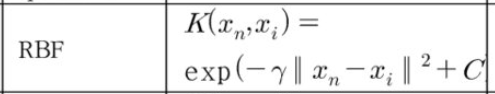

The RBF kernel formula helps to determine how close the two values (input and reference) are. 

- **Duration Column:** We will consider our reference value as the percentiles of the duration, such as the 25th, 50th, and 75th percentiles. 
- We will calculate the similarity between the duration column and its percentiles, determining how close all the duration values are to the 25th, 50th, and 75th percentiles using the sklearn RBF kernel.

#### Parameters
- **x:** The input value, which is an \( n \times p \) matrix. For our case, it is the duration, which is \( n \times 1 \).
- **y:** The percentile, which is a \( 3 \times p \) matrix. When we calculate it using the formula, we get matrices of \( n \times 3 \). Each column will calculate the similarity with the 25th, 50th, and 75th percentiles for the duration.
- **gamma:** A hyperparameter to tune overfitting or underfitting.


In [127]:
# basic structure of a class

class RBFPercentileSimilarity():
    def __init__(self):
        pass

In [128]:
RBFPercentileSimilarity()

- `<__main__.RBFPercentileSimilarity at 0x184a4d917e0>` - This is a Python class.
- To convert it into a scikit-learn compatible class, we need to inherit `BaseEstimator` and `TransformerMixin`.


In [129]:
(
    X_train
    .duration
    .quantile([0.25, 0.5, 0.75])  # Calculate the 25th, 50th, and 75th percentiles of the duration column
    .values  # Convert the percentiles into an array
    .reshape(-1, 1)  # Reshape the array to have as many rows as needed, but only 1 column (3x1 array)
)
# This operation has to be performed on every column


array([[170.],
       [510.],
       [925.]])

In [130]:
class RBFPercentileSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, variables=None, percentiles=[0.25, 0.5, 0.75], gamma=0.1):
        self.variables = variables
        self.percentiles = percentiles
        self.gamma = gamma

    # Implement the fit method
    def fit(self, X, y=None):
        # If the user has not specified the variables, identify all numeric variables in the dataset
        if not self.variables:
            self.variables = X.select_dtypes(include="number").columns.to_list()
        
        # Calculate the reference values (percentiles) for each variable
        self.reference_values_ = {
            col: (
                X
                .loc[:, col]
                .quantile(self.percentiles)
                .values
                .reshape(-1, 1)
            )
            for col in self.variables
        }
        
        return self

    # Implement the transform method
    def transform(self, X):
        objects = []
        for col in self.variables:
            # Create column names based on the percentiles
            columns = [f"{col}_rbf_{int(percentiles*100)}" for percentiles in self.percentiles]
            # Calculate the RBF kernel similarity and store it in a DataFrame
            obj = pd.DataFrame(
                data=rbf_kernel(X.loc[:, [col]], Y=self.reference_values_[col], gamma=self.gamma),
                columns=columns
            )
            objects.append(obj)
        # Concatenate the transformed columns horizontally
        return pd.concat(objects, axis=1)


In [131]:
RBFPercentileSimilarity().fit_transform(X_train.loc[:, ["duration"]])

,duration_rbf_25,duration_rbf_50,duration_rbf_75
0,8.208500e-02,0.000000e+00,0.000000e+00
1,0.000000e+00,0.000000e+00,0.000000e+00
2,0.000000e+00,0.000000e+00,0.000000e+00
3,7.187782e-28,0.000000e+00,0.000000e+00
4,1.125982e-278,0.000000e+00,0.000000e+00
...,...,...,...
6690,0.000000e+00,0.000000e+00,1.668157e-314
6691,0.000000e+00,3.240271e-184,0.000000e+00
6692,0.000000e+00,0.000000e+00,0.000000e+00
6693,0.000000e+00,8.208500e-02,0.000000e+00


- **Observation**
    - Input: We provided the duration column.
    - Output: It gave us `duration_rbf_25`, `duration_rbf_50`, and `duration_rbf_75`.
    - If we had given the whole dataset (`X_train`), it would have automatically identified the numeric variables and provided the results.
    - For the duration column, it calculates how close each value is with respect to the percentile values.
    - The percentiles we calculated are the reference values.


- Now, the next part we have to do is power transformation.


In [132]:
# Define a pipeline for duration feature engineering
duration_pipe1 = Pipeline(steps=[
    ("rbf", RBFPercentileSimilarity()),  # Apply RBF Percentile Similarity transformation
    ("scaler", PowerTransformer())       # Apply Power Transformation
])

duration_pipe2 = Pipeline(steps=[
    ("cat", FunctionTransformer(func=duration_category)),  # Categorize duration
    ("encoder", OrdinalEncoder(categories=[["short", "medium", "long"]]))  # Encode categories as ordinal
])

duration_union = FeatureUnion(transformer_list=[
    ("part1", duration_pipe1),  # RBF Percentile Similarity + Power Transformation
    ("part2", duration_pipe2),  # Duration Categorization + Ordinal Encoding
    ("part3", FunctionTransformer(func=is_over)),  # Create binary column for duration over a specified value
    ("part4", StandardScaler())  # Standardize the features
])

# Define a pipeline for overall duration transformation
duration_transformer = Pipeline(steps=[
    ("outliers", Winsorizer(capping_method="iqr", fold=1.5)),  # Handles outliers using Winsorization
    ("imputer", SimpleImputer(strategy="median")),  # Imputes missing values using median strategy
    ("union", duration_union)  # Combines all transformations using FeatureUnion
])

# Fit and transform the duration column in X_train
duration_transformer.fit_transform(X_train.loc[:, ["duration"]])


,duration_rbf_25,duration_rbf_50,duration_rbf_75,duration_cat,duration_over_1000,duration
0,2.410433,-0.107678,-0.090538,0.0,0,-0.939504
1,-0.361632,-0.107678,-0.090538,2.0,1,1.861606
2,-0.361632,-0.107678,-0.090538,2.0,1,1.038341
3,-0.361632,-0.107678,-0.090538,1.0,0,-0.879265
4,-0.361632,-0.107678,-0.090538,0.0,0,-1.090101
...,...,...,...,...,...,...
6690,-0.361632,-0.107678,-0.090538,2.0,0,0.415872
6691,-0.361632,-0.107678,-0.090538,2.0,0,-0.116238
6692,-0.361632,-0.107678,-0.090538,2.0,1,2.052363
6693,-0.361632,9.394283,-0.090538,2.0,0,-0.256796


### 4.6 total_stops

In [133]:
X_train.total_stops

0       0.0
1       2.0
2       1.0
3       0.0
4       0.0
       ... 
6690    1.0
6691    1.0
6692    1.0
6693    1.0
6694    0.0
Name: total_stops, Length: 6695, dtype: float64

In [134]:
def is_direct(X):
    return X.assign(is_direct_flight=X.total_stops.eq(0).astype(int))


total_stops_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("", FunctionTransformer(func=is_direct))
])

total_stops_transformer.fit_transform(X_train.loc[:, ["total_stops"]])

,total_stops,is_direct_flight
0,0.0,1
1,2.0,0
2,1.0,0
3,0.0,1
4,0.0,1
...,...,...
6690,1.0,0
6691,1.0,0
6692,1.0,0
6693,1.0,0


### 4.7 additional_info

In [135]:
X_train.additional_info

0                           No Info
1                           No Info
2       In-flight meal not included
3                           No Info
4                           No Info
                   ...             
6690                        No Info
6691                        No Info
6692    In-flight meal not included
6693                        No Info
6694                        No Info
Name: additional_info, Length: 6695, dtype: object

In [136]:
info_pipe1 = Pipeline(steps=[
    ("group", RareLabelEncoder(tol=0.1, n_categories=2, replace_with="Other")),
    ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

info_pipe1.fit_transform(X_train.loc[:, ["additional_info"]])

# part1- we are grouping the rare categories
# then will apply one hot encoder

,additional_info_In-flight meal not included,additional_info_No Info,additional_info_Other
0,0.0,1.0,0.0
1,0.0,1.0,0.0
2,1.0,0.0,0.0
3,0.0,1.0,0.0
4,0.0,1.0,0.0
...,...,...,...
6690,0.0,1.0,0.0
6691,0.0,1.0,0.0
6692,1.0,0.0,0.0
6693,0.0,1.0,0.0


In [137]:
# part2: here here we are creating an another binary column here eherever the value is no info make it 0 for all the other categories make it 1

def have_info(X):
    return X.assign(additional_info=X.additional_info.ne("No Info").astype(int))

In [138]:
info_union = FeatureUnion(transformer_list=[
    ("part1", info_pipe1),
    ("part2", FunctionTransformer(func=have_info))
])

In [139]:
info_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="unknown")),
    ("union", info_union)
])

info_transformer.fit_transform(X_train.loc[:, ["additional_info"]])

,additional_info_In-flight meal not included,additional_info_No Info,additional_info_Other,additional_info
0,0.0,1.0,0.0,0
1,0.0,1.0,0.0,0
2,1.0,0.0,0.0,1
3,0.0,1.0,0.0,0
4,0.0,1.0,0.0,0
...,...,...,...,...
6690,0.0,1.0,0.0,0
6691,0.0,1.0,0.0,0
6692,1.0,0.0,0.0,1
6693,0.0,1.0,0.0,0


## 5. Column Transformer

In [140]:
column_transformer = ColumnTransformer(transformers=[
    ("air", airline_transformer, ["airline"]),
    ("doj", doj_transformer, ["date_of_journey"]),
    ("location", location_transformer, ["source", "destination"]), # on source and destination column it will perform the location_transformer transformation 
    ("time", time_transformer, ["dep_time", "arrival_time"]),
    ("dur", duration_transformer, ["duration"]),
    ("stops", total_stops_transformer, ["total_stops"]),
    ("info", info_transformer, ["additional_info"])
], remainder="passthrough")

column_transformer.fit_transform(X_train, y_train)

,air__airline_Air India,air__airline_Indigo,air__airline_Jet Airways,air__airline_Multiple Carriers,air__airline_other,doj__date_of_journey_month,doj__date_of_journey_week,doj__date_of_journey_day_of_week,doj__date_of_journey_day_of_year,location__source,location__destination,location__source_is_north,location__destination_is_north,time__dep_time_hour,time__dep_time_minute,time__arrival_time_hour,time__arrival_time_minute,time__dep_time_part_of_day,time__arrival_time_part_of_day,dur__duration_rbf_25,dur__duration_rbf_50,dur__duration_rbf_75,dur__duration_cat,dur__duration_over_1000,dur__duration,stops__total_stops,stops__is_direct_flight,info__additional_info_In-flight meal not included,info__additional_info_No Info,info__additional_info_Other,info__additional_info
0,0.0,1.0,0.0,0.0,0.0,1.000000,0.823529,0.500000,0.822034,-0.154666,-0.173651,1,0,0.869565,0.454545,1.000000,0.181818,0.118398,1.000000,2.410433,-0.107678,-0.090538,0.0,0,-0.939504,0.0,1,0.0,1.0,0.0,0
1,1.0,0.0,0.0,0.0,0.0,0.666667,0.705882,0.166667,0.686441,1.042355,1.040402,1,0,0.739130,0.272727,0.826087,0.272727,0.203345,0.654271,-0.361632,-0.107678,-0.090538,2.0,1,1.861606,2.0,0,0.0,1.0,0.0,0
2,0.0,0.0,1.0,0.0,0.0,0.000000,0.176471,1.000000,0.194915,-0.154666,-0.173651,1,0,0.913043,0.181818,0.695652,0.363636,0.118398,0.654271,-0.361632,-0.107678,-0.090538,2.0,1,1.038341,1.0,0,1.0,0.0,0.0,1
3,0.0,1.0,0.0,0.0,0.0,0.333333,0.294118,0.000000,0.262712,1.042355,1.040402,1,0,0.608696,0.363636,0.739130,0.636364,0.000000,0.654271,-0.361632,-0.107678,-0.090538,1.0,0,-0.879265,0.0,1,0.0,1.0,0.0,0
4,0.0,0.0,1.0,0.0,0.0,0.000000,0.117647,0.666667,0.118644,-1.853893,-0.834662,1,0,0.434783,0.363636,0.478261,0.909091,1.000000,0.937688,-0.361632,-0.107678,-0.090538,0.0,0,-1.090101,0.0,1,0.0,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6690,0.0,0.0,1.0,0.0,0.0,0.666667,0.588235,0.500000,0.584746,-0.154666,-0.173651,1,0,0.391304,0.636364,1.000000,0.636364,1.000000,1.000000,-0.361632,-0.107678,-0.090538,2.0,0,0.415872,1.0,0,0.0,1.0,0.0,0
6691,0.0,0.0,1.0,0.0,0.0,0.666667,0.647059,0.833333,0.661017,-0.154666,-0.173651,1,0,0.391304,0.636364,0.826087,0.181818,1.000000,0.654271,-0.361632,-0.107678,-0.090538,2.0,0,-0.116238,1.0,0,0.0,1.0,0.0,0
6692,0.0,0.0,1.0,0.0,0.0,0.666667,0.705882,0.666667,0.711864,-0.154666,-0.173651,1,0,0.869565,0.000000,1.000000,0.636364,0.118398,1.000000,-0.361632,-0.107678,-0.090538,2.0,1,2.052363,1.0,0,1.0,0.0,0.0,1
6693,0.0,0.0,0.0,1.0,0.0,1.000000,0.823529,0.000000,0.796610,1.042355,1.040402,1,0,0.434783,0.636364,0.826087,0.000000,1.000000,0.654271,-0.361632,9.394283,-0.090538,2.0,0,-0.256796,1.0,0,0.0,1.0,0.0,0


## 6 Feature Selection

### Column Transformer and Pipeline with Feature Selector

- We will use a `ColumnTransformer` to create all the transformed columns.
- On top of the `ColumnTransformer`, we will include a feature selector as the last step in the pipeline.
- In one pipeline, we will have the `ColumnTransformer` and then a feature selection algorithm.

### Process Explanation

- The pipeline will run, creating all the features.
- Based on the feature selection algorithm, some features will be dropped.

### How the Feature Selection Algorithm Works

- The algorithm takes an estimator; we will use a `RandomForestRegressor`.
- Scoring will be done using `roc_auc` for classification problems, or `r2` for regression problems.
- The algorithm will run `RandomForest` on each variable individually (e.g., duration vs price, additional info vs price, departure time vs price, etc.) so it will train 30 models
- after calculating it will evaluate the r2 score for each model 
- It will compare the performance of each variable.
- whicheever feathure the threshold is 0.1 i.e feature which has r2 score over 10% retain that 
- Features that show top performance will be retained, and those with lesser performance will be removed.


In [141]:
 estimator = RandomForestRegressor(n_estimators=10, max_depth=3, random_state=42)

selector = SelectBySingleFeaturePerformance(
    estimator=estimator,
    scoring="r2",
    threshold=0.1
) 

## 6. Putting it all Together

In [142]:
preprocessor = Pipeline(steps=[
    ("ct", column_transformer),
    ("selector", selector)  
])

preprocessor.fit_transform(X_train, y_train)

,air__airline_Indigo,air__airline_Jet Airways,air__airline_other,doj__date_of_journey_week,doj__date_of_journey_day_of_year,location__source,location__destination,dur__duration_rbf_25,dur__duration_cat,dur__duration_over_1000,dur__duration,stops__total_stops,stops__is_direct_flight
0,1.0,0.0,0.0,0.823529,0.822034,-0.154666,-0.173651,2.410433,0.0,0,-0.939504,0.0,1
1,0.0,0.0,0.0,0.705882,0.686441,1.042355,1.040402,-0.361632,2.0,1,1.861606,2.0,0
2,0.0,1.0,0.0,0.176471,0.194915,-0.154666,-0.173651,-0.361632,2.0,1,1.038341,1.0,0
3,1.0,0.0,0.0,0.294118,0.262712,1.042355,1.040402,-0.361632,1.0,0,-0.879265,0.0,1
4,0.0,1.0,0.0,0.117647,0.118644,-1.853893,-0.834662,-0.361632,0.0,0,-1.090101,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6690,0.0,1.0,0.0,0.588235,0.584746,-0.154666,-0.173651,-0.361632,2.0,0,0.415872,1.0,0
6691,0.0,1.0,0.0,0.647059,0.661017,-0.154666,-0.173651,-0.361632,2.0,0,-0.116238,1.0,0
6692,0.0,1.0,0.0,0.705882,0.711864,-0.154666,-0.173651,-0.361632,2.0,1,2.052363,1.0,0
6693,0.0,0.0,0.0,0.823529,0.796610,1.042355,1.040402,-0.361632,2.0,0,-0.256796,1.0,0


## 7. Visualizations

In [148]:
#preprocessor.named_steps

In [150]:
#preprocessor.named_steps["selector"]



- Each selector object has an attribute called `feature_importances_`.
- This attribute provides the importance of each feature based on its R2 score.
- We will use this attribute to access and evaluate our feature importances.


In [146]:
preprocessor

Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('air',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('grouper',
                                                                   RareLabelEncoder(n_categories=2,
                                                                                    replace_with='other',
                                                                                    tol=0.1)),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['airline']),
                                                 ('doj',
                                                  Pipeline(steps=[('dt',
                                                                   Datetime...
                                                                                                                                     replace_with='Other',
                                                                                                                                     tol=0.1)),
                                                                                                                   ('encoder',
                                                                                                                    OneHotEncoder(handle_unknown='ignore',
                                                                                                                                  sparse_output=False))])),
                                                                                                  ('part2',
                                                                                                   FunctionTransformer(func=<function have_info at 0x000001D4885DFAC0>))]))]),
                                                  ['additional_info'])])),
                ('selector',
                 SelectBySingleFeaturePerformance(estimator=RandomForestRegressor(max_depth=3,
                                                                                  n_estimators=10,
                                                                                  random_state=42),
                                                  scoring='r2',
                                                  threshold=0.1))])

In [143]:
feature_performances = preprocessor.named_steps["selector"].feature_performance_
feature_performances

{'air__airline_Air India': 0.001299110941331801,
 'air__airline_Indigo': 0.12667945650961468,
 'air__airline_Jet Airways': 0.1850751075717253,
 'air__airline_Multiple Carriers': 0.020749196471709547,
 'air__airline_other': 0.11789108107085551,
 'doj__date_of_journey_month': 0.08816144479446623,
 'doj__date_of_journey_week': 0.1876372731467039,
 'doj__date_of_journey_day_of_week': 0.003177944784714041,
 'doj__date_of_journey_day_of_year': 0.23321076672923755,
 'location__source': 0.13453297055162697,
 'location__destination': 0.13903972929809408,
 'location__source_is_north': 0.03695972964819072,
 'location__destination_is_north': 0.03695972964819072,
 'time__dep_time_hour': 0.010193870797225743,
 'time__dep_time_minute': 0.03663676648274158,
 'time__arrival_time_hour': 0.08108978495518937,
 'time__arrival_time_minute': 0.03544931738827103,
 'time__dep_time_part_of_day': -0.0012103051419907935,
 'time__arrival_time_part_of_day': 0.0328573012939819,
 'dur__duration_rbf_25': 0.11644717313

In [144]:
sorted_feat_imp = dict(sorted(feature_performances.items(), key=lambda val: val[1], reverse=True))
sorted_feat_imp

{'dur__duration': 0.44154279956562403,
 'stops__total_stops': 0.4074489760203444,
 'dur__duration_cat': 0.4052166455576309,
 'stops__is_direct_flight': 0.3846812576049535,
 'doj__date_of_journey_day_of_year': 0.23321076672923755,
 'doj__date_of_journey_week': 0.1876372731467039,
 'air__airline_Jet Airways': 0.1850751075717253,
 'location__destination': 0.13903972929809408,
 'location__source': 0.13453297055162697,
 'air__airline_Indigo': 0.12667945650961468,
 'air__airline_other': 0.11789108107085551,
 'dur__duration_rbf_25': 0.11644717313538282,
 'dur__duration_over_1000': 0.1095888102852783,
 'doj__date_of_journey_month': 0.08816144479446623,
 'time__arrival_time_hour': 0.08108978495518937,
 'location__source_is_north': 0.03695972964819072,
 'location__destination_is_north': 0.03695972964819072,
 'time__dep_time_minute': 0.03663676648274158,
 'time__arrival_time_minute': 0.03544931738827103,
 'time__arrival_time_part_of_day': 0.0328573012939819,
 'air__airline_Multiple Carriers': 0.0

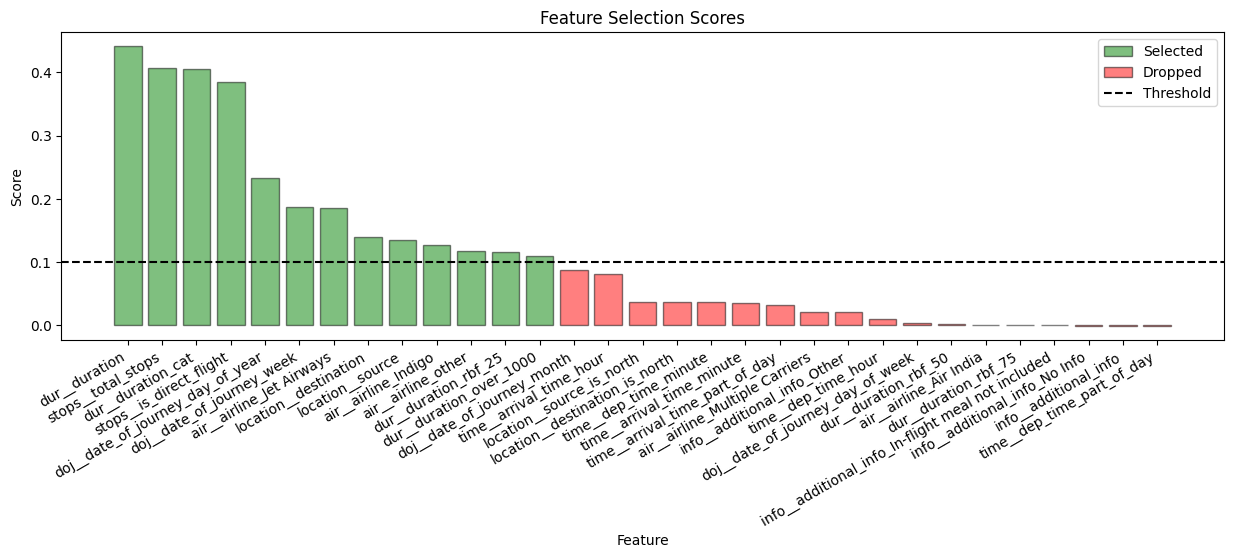

In [151]:
THRESHOLD = 0.1

selected_bar = None
dropped_bar = None
colors = ["red" if score < THRESHOLD else "green" for score in sorted_feat_imp.values()]

fig, ax = plt.subplots(figsize=(15, 4)) 

for i, (feature, score) in enumerate(sorted_feat_imp.items()):
    params = dict(
        x=i,
        height=score,
        edgecolor="black",
        alpha=0.5
    )
    
    if score < THRESHOLD:
        bar = ax.bar(
            color="red",
            **params
        )
        if not dropped_bar:
            dropped_bar = bar[0]
    else:
        bar = ax.bar(
            color="green",
            **params
        )
        if not selected_bar:
            selected_bar = bar[0]

thresh_line = ax.axhline(
    y=0.1,
    color="black",
    linestyle="--"
)

ax.set_xticks(
    ticks=range(len(sorted_feat_imp)),
    labels=list(sorted_feat_imp.keys()),
    rotation=30,
    ha="right"
)

ax.set(
    xlabel="Feature",
    ylabel="Score",
    title="Feature Selection Scores"
)

ax.legend(
    handles=[selected_bar, dropped_bar, thresh_line],
    labels=["Selected", "Dropped", "Threshold"],
    loc="upper right"
)

plt.show()


### Conclusion

- Post feature engineering, we have a total of 31 columns.
- The feature selector algorithm selected 13 features out of these.
